<a href="https://colab.research.google.com/github/imiled/DL_Tools_For_Finance/blob/master/RNN_time_series_colab_student_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting

This notebook is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

We mostly follow the Tensroflow Tutorial, that you can find here:

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>


  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br></br>


It also follows partialy some of the material prepared by François Chollet (the creator of Keras) for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).


In [ ]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

## The weather dataset
This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. 


In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Let's take a look at the columns:

In [ ]:
df.shape
df.columns.shape

(15,)

In [ ]:
df.shape

(420551, 15)


Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict (e.g. 6 hours, or 60 events). This `target_size` is applied to the dataset to get  the label that needs to be predicted.


The image below (from <a href=https://eng.uber.com/omphalos/>Uber Engineering</a>) depicts how the feature/label split is made:

<img src="http://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/01/image3-4.png" width="400px">

In [ ]:
df.

TypeError: ignored

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  #reultat lista de lista
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    features=dataset[indices]
    
    data.append(features.reshape(history_size,1))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


In the following, the first 300,000 rows of the data will be the training dataset, and the remaining will be the validation dataset. This amounts to ~2100 days worth of training data.


In [ ]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [ ]:
tf.random.set_seed(13)

## Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']  

Let's observe how this data looks across time.

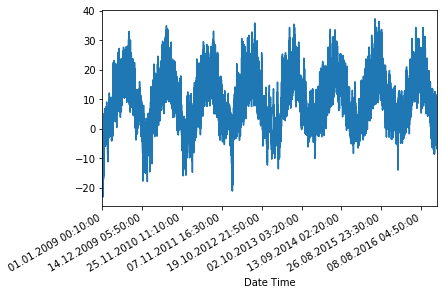

In [ ]:
uni_data.plot(subplots=True)
plt.show()

In [ ]:
# keep just the values to feed the network
uni_data = uni_data.values

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [ ]:
#normalisation des datas uniquement sur le traib
mean_train=uni_data[:TRAIN_SPLIT].mean()
std_train=uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [ ]:
uni_data_nor = (uni_data-mean_train)/std_train
print(uni_data_nor.min(),uni_data_nor.max(),uni_data_nor.mean(),uni_data_nor.std())

-3.733275458038647 3.247383544605265 0.0251126636394392 0.9752955760381984


Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

Basically, we are expecting that each point is autocorraleted with the previous 20 events, and then the autocorrelation fades away. Take a look at this <a href="https://www.quantstart.com/articles/Serial-Correlation-in-Time-Series-Analysis">great explanation of autocorrelation in a Quant blog.</a>


In [ ]:
univariate_past_history = 20
univariate_future_target = 5


x_train_uni, y_train_uni = univariate_data(dataset=uni_data_nor,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT-univariate_future_target,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data_nor,
                                           start_index=TRAIN_SPLIT,
                                           end_index=uni_data_nor.shape[0]-+univariate_future_target,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)

In [ ]:
x_train_uni,y_train_uni

(array([[[-1.99766294],
         [-2.04281897],
         [-2.05439744],
         ...,
         [-2.08913285],
         [-2.09260639],
         [-2.10418486]],
 
        [[-2.04281897],
         [-2.05439744],
         [-2.0312405 ],
         ...,
         [-2.09260639],
         [-2.10418486],
         [-2.10418486]],
 
        [[-2.05439744],
         [-2.0312405 ],
         [-2.02660912],
         ...,
         [-2.10418486],
         [-2.10418486],
         [-2.09492208]],
 
        ...,
 
        [[ 0.68738403],
         [ 0.68391049],
         [ 0.68391049],
         ...,
         [ 0.65264863],
         [ 0.65264863],
         [ 0.64801724]],
 
        [[ 0.68391049],
         [ 0.68391049],
         [ 0.68275265],
         ...,
         [ 0.65264863],
         [ 0.64801724],
         [ 0.6445437 ]],
 
        [[ 0.68391049],
         [ 0.68275265],
         [ 0.68275265],
         ...,
         [ 0.64801724],
         [ 0.6445437 ],
         [ 0.6445437 ]]]),
 array([-2.10418486

This is what the `univariate_data` function returns.

In [ ]:
idx = np.random.randint(0, TRAIN_SPLIT)
print ('Single window of past history')
print (x_train_uni[idx])
print ('\n Target temperature to predict')
print (y_train_uni[idx])

Single window of past history
[[-0.09300478]
 [-0.09647832]
 [-0.09647832]
 [-0.10110971]
 [-0.07679493]
 [-0.06521646]
 [-0.05595368]
 [-0.06058507]
 [-0.06984784]
 [-0.08953124]
 [-0.13352942]
 [-0.16826483]
 [-0.17289622]
 [-0.13816081]
 [-0.0490066 ]
 [ 0.04825254]
 [ 0.08646149]
 [ 0.09225072]
 [ 0.09572426]
 [ 0.11309197]]

 Target temperature to predict
0.15245876204311937


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [ ]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

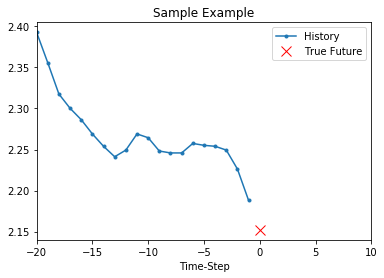

In [ ]:
idx = np.random.randint(0, TRAIN_SPLIT)
show_plot([x_train_uni[idx], y_train_uni[idx]], 0, 'Sample Example')
plt.show()

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations. This simple baseline is known as the Moving Average (MA), and there are fancier versions of it such as the Wieghthed Moving Average (WMA) and the Exponential Moving Average (EMA). Take a look at this blog, again from the <a href="https://towardsdatascience.com/trading-toolbox-02-wma-ema-62c22205e2a9">financial world<a>. 

In [ ]:
def baseline(history):
  # return the mean
  return np.mean(history)

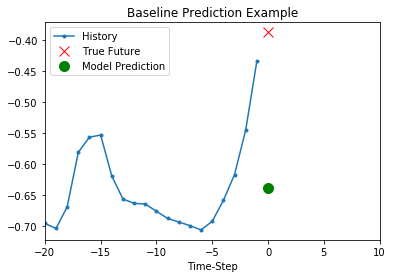

In [ ]:
idx = np.random.randint(0, TRAIN_SPLIT)
show_plot([x_train_uni[idx], y_train_uni[idx], baseline(x_train_uni[idx])], 0, 
          'Baseline Prediction Example')
plt.show()

Let's see if you can beat this baseline using a recurrent neural network. Just for comparison, the WMA would be simply:

In [ ]:
def baseline_wma(history):
  history = np.squeeze(history)
  weights = np.arange(history.size)
  history_weighted = history.dot(weights)/weights.sum()
  return np.mean(history_weighted)

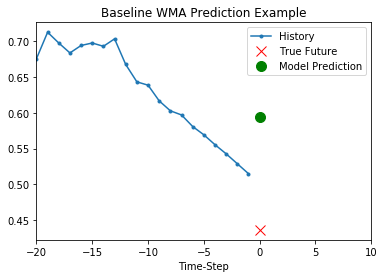

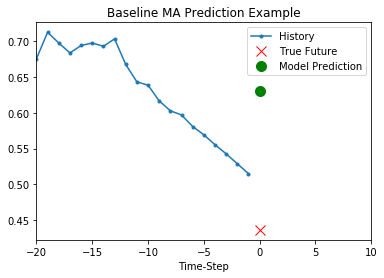

In [ ]:
idx = np.random.randint(0, TRAIN_SPLIT)
show_plot([x_train_uni[idx], y_train_uni[idx], baseline_wma(x_train_uni[idx])], 0, 
          'Baseline WMA Prediction Example')
plt.show()

show_plot([x_train_uni[idx], y_train_uni[idx], baseline(x_train_uni[idx])], 0, 
          'Baseline MA Prediction Example')
plt.show()

### Recurrent neural network

As we already now, RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. 


In [ ]:
x_train_uni.shape,y_train_uni.shape

((299975, 20, 1), (299975,))

#### Data preparation
Let's now use the module`tf.data` to shuffle, batch, and cache the dataset. 
This module comes in quite handy for large datasets, that have to be processed from separated files.

In [ ]:
x_train_uni.shape, y_train_uni.shape

((299980, 20, 1), (299980,))

Note that we have 20 time steps, and just 1 feature. Now, we want to batch the first dimension:


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

<img src="https://www.tensorflow.org/tutorials/structured_data/images/time_series.png" width="300px">

#### LSTM model


You will see the LSTM requires the input shape of the data it is being given.

In [ ]:
x_train_uni.shape

(299975, 20, 1)

In [ ]:
from tensorflow.keras.layers import LSTM , Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

tf.keras.backend.clear_session()
print('Creating Model')

# create the model. The input to the LSTM is batch_input_shape=(batch_size, tsteps, input_dim)
model=Sequential()
model.add(LSTM(units=50,
               input_shape=x_train_uni.shape[1:],
               return_sequences=True
               )) 
model.add(LSTM(units=50,
               
               return_sequences=False
               ) )
model.add(Dense(1))
model.compile(loss='mse',optimizer=RMSprop())
model.summary()

Creating Model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
simple_lstm_model = ?

SyntaxError: ignored

Let's make a sample prediction, to check the output of the model. 

In [ ]:
for x, y in val_univariate.take(1):
    print(model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

h = model.fit(train_univariate,
              epochs=EPOCHS,
              steps_per_epoch=EVALUATION_INTERVAL,
              validation_data=val_univariate,
              validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 27ms/step - loss: 0.0600 - val_loss: 0.0149
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0189 - val_loss: 0.0098
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0172 - val_loss: 0.0090
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0136 - val_loss: 0.0077
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0107 - val_loss: 0.0087
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0123 - val_loss: 0.0067
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0108 - val_loss: 0.0068
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0111 - val_loss: 0.0076
Epoch 10/10
200/200 [==============================] - 2

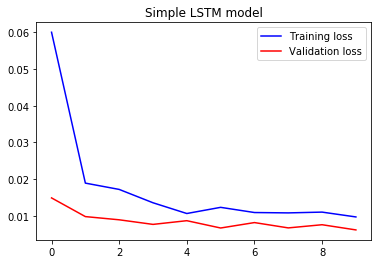

In [ ]:
plot_train_history(h, 'Simple LSTM model')

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

Note that the dataset is made up of tensors, rather than actual numy arrays, and thus it has to be evaluated first. This is the main difference between tf 1.x and tf 2.x: in tf <2.x we would have to create a session to access the actual values of the tensor; now, we can convert them to numpy arrays directly!!


In [ ]:
values = val_univariate.take(1)
# values is not evaluated yet
print(values)

for x,y in values:
  # note that x and y contain a whole batch!
  print(x[0].numpy(), y[0].numpy())

<TakeDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
[[0.642228  ]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63643877]
 [0.63180738]
 [0.62949169]
 [0.62949169]
 [0.62601815]
 [0.62138676]
 [0.61907107]
 [0.61328183]
 [0.6074926 ]
 [0.60633475]
 [0.60401906]
 [0.60054552]
 [0.60054552]] 0.588967046003437


Predicitions for one sample
********************


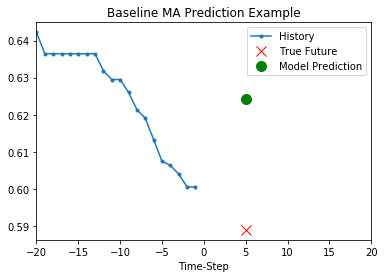

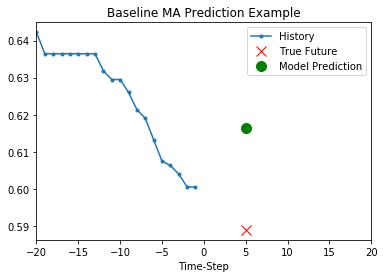

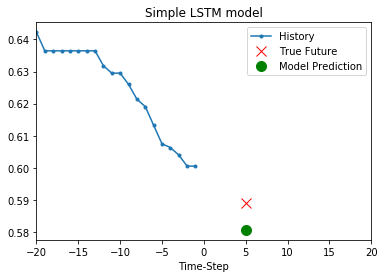

Predicitions for one sample
********************


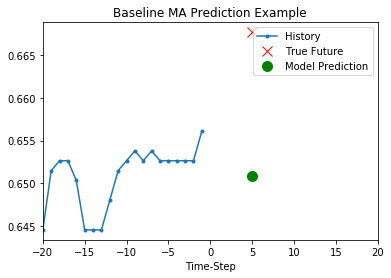

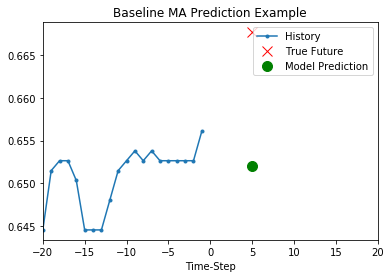

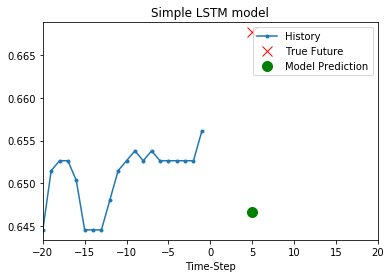

Predicitions for one sample
********************


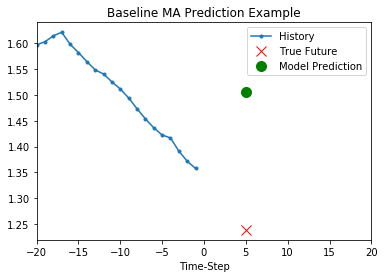

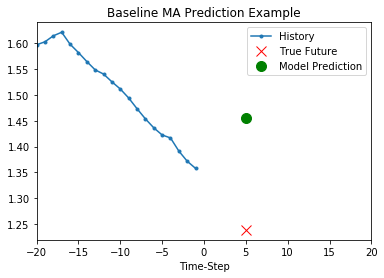

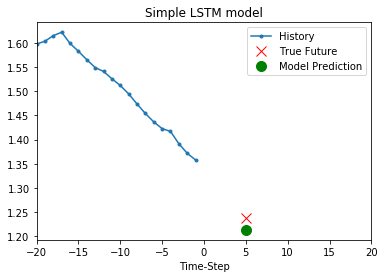

In [ ]:
for x, y in val_univariate.take(3):
  print("Predicitions for one sample")
  print("*"*20)

  xx, yy = x[0].numpy(), y[0].numpy()
  plot = show_plot([xx, yy, baseline(xx)], 5, 
          'Baseline MA Prediction Example')
  plot.show()
  plot = show_plot([xx, yy, baseline_wma(xx)], 5, 
          'Baseline MA Prediction Example')
  plot.show()
  lstm_pred = model.predict(x)[0]
  plot = show_plot([xx, yy, lstm_pred], 5, 'Simple LSTM model')
  plot.show()

#### Evaluation


In [ ]:
def evaluate_baseline(model, x_data, y_data):
  # calculate the mae for baseline models
  pred=[model(x) for x in x_data ]
  mae=np.mean([np.abs(y-p) for y, p in zip(y_data,pred)])
  return mae

In [ ]:
baseline(x_val_uni)

0.0877655085446114

In [ ]:
mae_b = evaluate_baseline(baseline, x_val_uni, y_val_uni)
mae_b2 = evaluate_baseline(baseline_wma, x_val_uni, y_val_uni)
mae = model.evaluate(val_univariate, steps=1000)

print("MAE for basline MA is %.4f" %mae_b)
print("MAE for basline WMA is %.4f" %mae_b2)
print("MAE for LSTM is %.4f" %mae)

1000/1000 [==============================] - 3s 3ms/step - loss: 0.0089
MAE for basline MA is 0.1775
MAE for basline WMA is 0.1423
MAE for LSTM is 0.0089


This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

#### Can you get a better result with the univariate LSTM?




In [ ]:
# try clipping gradients, stacked LSTMs, more epochs, etc.
?

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list (how would you pick them, BTW?).

In [ ]:
df.columns

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [ ]:
features = ?

Let's have a look at how each of these features vary across time.

In [ ]:
features.plot(subplots=True, figsize=(8,6))
plt.show()

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [ ]:
# keep only the values, and normalize
dataset = ?

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

The network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes (and RNN do handle well very long sequences!!). Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

Excercise: what if we smooth the data withtin an hour?



In [ ]:
past_history = 720
future_target = 72
STEP = 6
SINGLE_STEP = True

x_train_single, y_train_single = ?
x_val_single, y_val_single = ?

Let's look at the shape of a single data-point.



In [ ]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
single_step_model = ?

Let's check out a sample prediction.

In [ ]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

In [ ]:
# train
EPOCHS = 15
EVALUATION_INTERVAL = 200
single_step_history = ?

In [ ]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

In [ ]:
for x, y in val_data_single.take(3):
  plot = show_plot([?, # temperature history
                    ?, # temperature future
                    ? # prediction
                    ], 
                    ? # steps into the future,
                   'Single Step Prediction')
  plot.show()

#### Evaluate the model

In [ ]:
x_val_single.shape, y_val_single.shape

((119759, 120, 3), (119759,))

In [ ]:
mae_b = evaluate_baseline(baseline, x_val_single[:, 1], y_val_single)
mae_b2 = evaluate_baseline(baseline_wma, x_val_single[:, 1], y_val_single)
mae = single_step_model.evaluate(val_data_single, steps=1000)

print("MAE for basline MA is %.4f" %mae_b)
print("MAE for basline WMA is %.4f" %mae_b2)
print("MAE for LSTM is %.4f" %mae)

#### Can you get a better result with the multivariate, single-step prediction, LSTM?




### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [ ]:
past_history = 720
future_target = 72
STEP = 6
SINGLE_STEP = False

x_train_multi, y_train_multi = ?
x_val_multi, y_val_multi = ?

Let's check out a sample data-point.

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

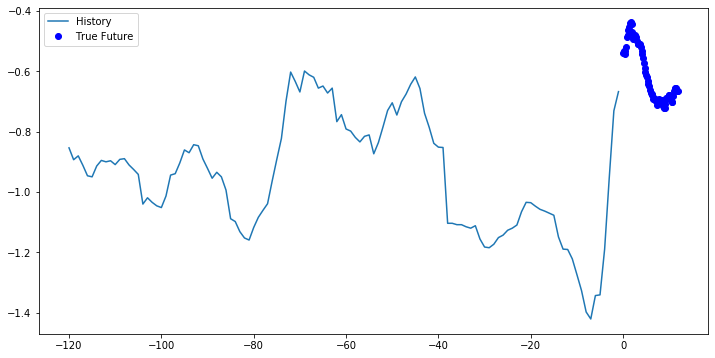

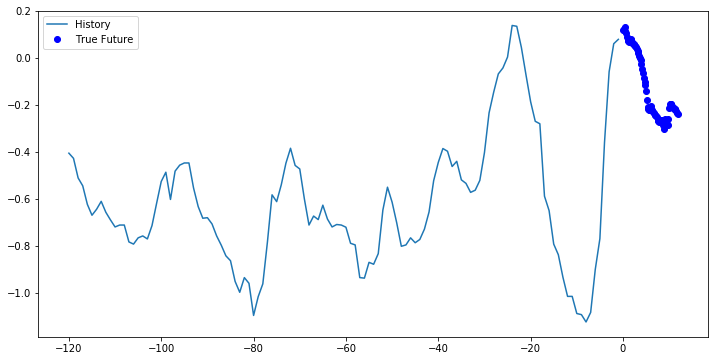

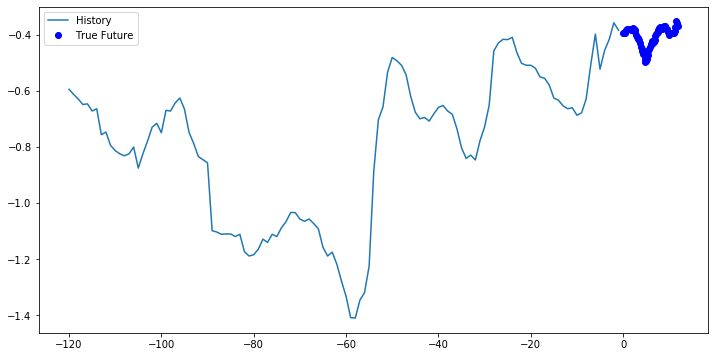

In [ ]:
for x, y in train_data_multi.take(3):
  multi_step_plot(x[0], y[0], np.array([0]))
  plt.show()

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

Note that we clip the value of the gradient so as to avoid the exploiding gradients effect that may appear with [long histories](https://medium.com/learn-love-ai/the-curious-case-of-the-vanishing-exploding-gradient-bf58ec6822eb). 

In [ ]:
multi_step_model = ?

Let's see how the model predicts before it trains.

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

In [ ]:
# train
EPOCHS = 10
EVALUATION_INTERVAL = 200

multi_step_history = ?

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## Next steps
In this class we have seen how to do time series forecasting using an RNN. You may now try to [predict the stock market](https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944) and become a billionaire ;) 

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/guide/data#time_series_windowing) guide and use it in this tutorial.

As we will see in the notebook "An implementation of sequence to sequence learning to perform addition", you may pose the problem of multi-Step prediction as a Sequence to Sequence model. For this, you first enconde the history with one (or multiple) RNN. Once you have this vector, you repeat it *n* times in the future, and use it as input to the decoder RNN, which is also feeded with the target at timestamp *t-1*. See this excellent [post](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/) to understand the nuts and bolts of multi-step forcasting. 

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

RNN have lots of applications, but the msot important ones are in the NLProc field, which we cover in the second module of the master. If you want to anticipate it, you might like to take a look at this tutotial, which shows how to [generate captions for an image](https://www.tensorflow.org/tutorials/text/image_captioning) using CNNs and RNNs with attention (this is advanced stuff, so don't hesitate asking should you try it!!),